In [1]:
import numpy as np
import pandas as pd
import pickle
import pymc3 as pm
from pymc3.math import cartesian
import scipy as sp
import theano
import theano.tensor as tt
import buqeyemodel as bq
import matplotlib.pyplot as plt
import os
%matplotlib inline

# BUQEYE Model

## Setup

First define the `ratio` function that will be used as the expansion parameter

In [2]:
# Constants: proton/neutron masses and hbar
m_p = 938.27208  # MeV/c^2
m_n = 939.56541  # MeV/c^2
hbarc = 197.33  # Mev-fm


def E_to_p(E_lab, interaction):
    """Return p in MeV.

    Parameters
    ----------
    energy      = float
                  lab energy given in MeV.
    interaction = str
                  {"pp", "nn", "np"}
    """

    if interaction == "pp":
        m1, m2 = m_p, m_p
    if interaction == "nn":
        m1, m2 = m_n, m_n
    if interaction == "np":
        m1, m2 = m_n, m_p
    p_rel = np.sqrt(
        E_lab * m2**2 * (E_lab + 2 * m1) /
        ((m1 + m2)**2 + 2 * m2 * E_lab)
        )
    return p_rel


def Q_approx(E, Lambda_b, interaction, single_expansion=False):
    if single_expansion:
        m_pi = 0
    else:
        m_pi = 138  # Set to 0 to just return p/Lambda_b
    # Interpolate to smooth the transition from m_pi to p
    n = 8
    p = E_to_p(E, interaction)
    q = (m_pi**n + p**n) / (m_pi**(n-1) + p**(n-1)) / Lambda_b
    return q


def ratio(X, Lambda_b):
    '''Assume energies are in the first column of X'''
    return Q_approx(X[:, 0], Lambda_b, interaction='np').ravel()

Now import the relevant data

In [3]:
dir_path = './observable_data/'
pot_type = 'kvnn_41'
observable = 'diff_cross_sec'
filename = observable + '_' + pot_type + '.csv'

df = pd.read_csv(
            filepath_or_buffer=os.path.join(dir_path, filename),
            index_col=['Energy', 'theta']
            )
idx = pd.IndexSlice

Now define the reference function as an interpolator of one of the orders

In [4]:
energy_all = np.arange(1, 351, 1)[:, None]
theta_all = np.arange(1, 180, 1)[:, None]
Xall = cartesian(energy_all, theta_all)
refs = df['5'].values
ref = sp.interpolate.LinearNDInterpolator(Xall, refs)

## Usage

Now that we have imported the data and defined both a `ratio` and `ref` function, we are ready to build the model and condition on data.

In [5]:
energy = np.array([96])[:, None]
theta = np.arange(1, 181, 35)[:, None]
X = cartesian(energy, theta)
df_reduced = df.loc[list(map(tuple, X))]
partials = df_reduced.loc[:, idx['0':'5']].values.T

In [6]:
ls = 35
ratio_kwargs = {'Lambda_b': 600}
max_index = 3
orders = np.array([0, 2, 3, 4, 5])
orders = orders[:max_index]
partials = partials[:max_index]
rm_orders = np.array([0])

observable = bq.GeoProcess()
observable.observe(X=X, partials=partials, ratio=ratio, orders=orders,
           rm_orders=rm_orders, ref=ref, ratio_kwargs=ratio_kwargs, ls=ls)

The `observable` object has been initialized with standard hyperparameters and has observed the partial sums that have been fed to it. Now we'd like to either predict the series value at unseen orders or interpolate some of the data that has been given to it already.

In [24]:
energy_new = np.array([96])[:, None]
theta_new = np.arange(1, 181, 1)[:, None]
Xnew = cartesian(energy_new, theta_new)
df_new = df.loc[list(map(tuple, Xnew))]
partials_new = df_new.loc[:, idx['0':'5']].values.T
partials_new = partials_new[:max_index]

The following code uses the `predict` method to compute a posterior for $\Delta_k$ and optionally rescale it by $X_\text{ref}$ and reshift by $X_k$.

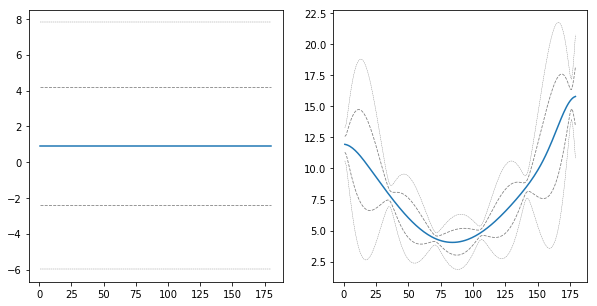

In [25]:
Xpred = Xnew
th = theta_new.ravel()

pred, interval = observable.predict(Xpred, rescale=False, dob=[0.68, 0.95])
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(th, pred)
axs[0].plot(th, interval[0].T, ls='--', c='gray', lw=0.8)
axs[0].plot(th, interval[1].T, ls='--', c='gray', lw=0.4)

pred, interval = observable.predict(Xpred, rescale=True, dob=[0.68, 0.95])
axs[1].plot(th, pred)
axs[1].plot(th, interval[0].T, ls='--', c='gray', lw=0.8)
axs[1].plot(th, interval[1].T, ls='--', c='gray', lw=0.4)

`conditional` works differently than `predict`. It interpolates the unseen values of a given order using knowledge of the underlying Gaussian process from the observed points. It too can be rescaled and reshifted.

In [26]:
# The true unseen values
coeffs_all, _ = bq.coefficients(partials, ratio, X=X, ref=ref(X), orders=orders, **ratio_kwargs)
coeffs_new, _ = bq.coefficients(partials_new, ratio, X=Xnew, ref=ref(Xnew), orders=orders, **ratio_kwargs)

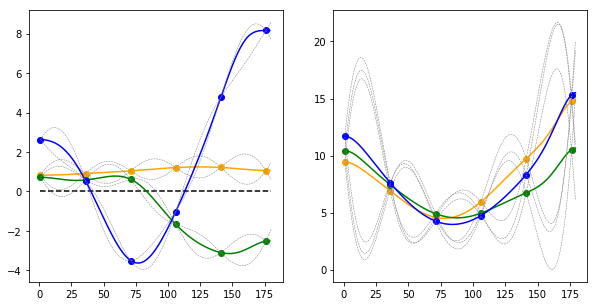

In [27]:
colors = ['orange', 'green', 'blue', 'red']
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(theta_new, np.zeros(len(theta_new)), c='k', ls='--')
for j, rescale in enumerate([False, True]):
    for i, order in enumerate(orders[:max_index]):
        cond, cond_int = observable.condition(Xnew=Xnew, order=order, rescale=rescale, dob=[0.68, 0.95])
        if rescale:
            truth = observable.partials[i]
            truth_new = partials_new[i]
        else:
            truth = coeffs_all[i]
            truth_new = coeffs_new[i]
        axs[j].plot(theta, truth, c=colors[i], ls='', marker='o')
        axs[j].plot(theta_new, truth_new, c=colors[i])
#         axs[j].plot(theta_new, cond, c=colors[i])
        axs[j].plot(theta_new, cond_int[1].T, c='gray', lw=0.5, ls='--')

We also have the ability to make posteriors for **general** parameters

In [11]:
# ls_array = np.arange(20, 70, 2)
# ls_pdf = observable.posterior('ls', ls=ls_array)
# plt.plot(ls_array, ls_pdf)